# SN Local and Global
This notebook contains:
* First analysis of SN on the local and global level.
* Contains the metrics plots.

PHD-10
* Newer more streamlined version from Documents/PhD/03_SN_global_different_windows_(nb25).ipynb
* ALl S/N calculation and bound are handled by function

# Preamble

In [1]:
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import xarray as xr
from importlib import reload
from glob import glob
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from enum import Enum
from dask.diagnostics import ProgressBar


In [2]:
import sys
sys.path.append('../')
sys.path.append('../modules')
# Custom xarray classes that addes different method.
import xarray_class_accessors as xca

# Custom plots for signal to noise functions.
import sn_plotting
import signal_to_noise as sn
import constants

In [3]:
# The directory where all of the longrun mip data used in this notebook is stored.
LONGRUNMIP_RETIMED_DIR = constants.LONGRUNMIP_RETIMED_DIR
LONGRUNMIP_RETIMED_DIR

'/g/data/w40/ab2313/PhD/longrunmip/regrid_retimestamped'

In [4]:
# It takes a while to run the loess filter for each grid cell. So this has been pre-generated and saved.
LONRUNMIP_LOESS_DIR = constants.LONRUNMIP_LOESS_DIR
LONRUNMIP_LOESS_DIR

'/g/data/w40/ab2313/PhD/longrunmip/regrid_retimestamped/loess'

In [5]:
# All the files that have been loess filtered. 
# TODO: Consistent naming format. Some files have _loess at the end, whilst others do not.
os.listdir(LONRUNMIP_LOESS_DIR)

['tas_ann_FAMOUS_control_3000_g025_loess.nc',
 'tas_mon_HadCM3L_abrupt4x_1000_g025_loess.nc',
 'tas_mon_CESM104_control_1000_g025_loess.nc',
 'tas_mon_HadCM3L_control_1000_g025_loess.nc',
 'tas_mon_MPIESM12_abrupt4x_999_g025_loess.nc',
 'tas_mon_ECHAM5MPIOM_abrupt4x_1001_g025_loess.nc',
 'tas_mon_GFDLESM2M_control_1340_g025_loess.nc',
 'tas_mon_MPIESM12_control_1237_g025_loess.nc',
 'tas_mon_GISSE2R_control_5225_g025_loess.nc',
 'tas_ann_GFDLESM2M_abrupt4x_150_g025_loess.nc',
 'tas_mon_GISSE2R_abrupt4x_5001_g025_loess.nc',
 'tas_mon_IPSLCM5A_control_1000_g025_loess.nc',
 'tas_mon_ECEARTH_control_508_g025_loess.nc',
 'tas_ann_MPIESM11_control_2000_g025_loess.nc',
 'tas_mon_CNRMCM61_control_2000_g025_loess.nc',
 'tas_mon_MIROC32_abrupt4x_150_g025_loess.nc',
 'tas_mon_CNRMCM61_abrupt4x_1850_g025_loess.nc',
 'tas_mon_GFDLCM3_control_5200_g025_loess.nc',
 'tas_mon_CCSM3_abrupt4x_2120_g025_loess.nc',
 'tas_ann_MPIESM11_abrupt4x_4459_g025_loess.nc',
 'tas_ann_GFDLCM3_abrupt4x_150_g025_loess.n

In [6]:
IMAGE_SAVE_DIR_INIT = constants.IMAGE_SAVE_DIR_INIT

In [7]:
class LocationsLatLon(Enum):
    '''Latittude and longitude of different locations around the world'''
    EPACIFIC = (2.7 ,-85)
    NATLANTIC = (2.2, -8)
    ECHINA_SEA = (26, 128)
    MELBOURNE = (-38, 145)
    LONDON = (51, 0.12)
    NY = (40, 74)
    BEIJING = (40, 116) 
    BUENOS_AIRES = (35, 58)
    KINSHASA = (4.4, 15.2)
    ARTIC = (76, 100)

In [8]:
constants.LONGRUMIP_MODELS

['ccsm3', 'cesm104', 'cnrmcm61', 'famoues', 'gisse2r', 'mpiesm11']

In [9]:
chunks = {'lat':48/2,'lon':96/2,'time':-1}

# Better Version

In [80]:
def get_exeriment_file_names() -> dict:

    FILE_NAME_METADATA_DICT = {'base_paths':{
                        'raw': LONGRUNMIP_RETIMED_DIR,
                        'loess':LONRUNMIP_LOESS_DIR
                                                }, 
                        'experiments' :['abrupt4x', 'control']}



    FILE_NAME_DICT = {}
    for name, base_path in FILE_NAME_METADATA_DICT['base_paths'].items():
    #     print(name)
        for exp in FILE_NAME_METADATA_DICT['experiments']:
            full_name = f'{exp}_{name}'
            print(full_name)
            fnames = list(map(os.path.basename, glob(os.path.join(base_path, f'*{exp}*'))))

            FILE_NAME_DICT[full_name] = {'base_path': base_path, 'file_names': fnames }
            
    return FILE_NAME_DICT

In [90]:
FILE_NAME_DICT = get_exeriment_file_names()

abrupt4x_raw
control_raw
abrupt4x_loess
control_loess


In [91]:
FILE_NAME_DICT.keys()

dict_keys(['abrupt4x_raw', 'control_raw', 'abrupt4x_loess', 'control_loess'])

In [92]:
FILE_NAME_DICT['abrupt4x_raw']['file_names']

['tas_mon_ECHAM5MPIOM_abrupt4x_1001_g025.nc',
 'tas_mon_ECEARTH_abrupt4x_150_g025.nc',
 'tas_ann_HadGEM2_abrupt4x_1299_g025.nc',
 'tas_mon_GISSE2R_abrupt4x_5001_g025.nc',
 'tas_mon_MPIESM12_abrupt4x_999_g025.nc',
 'tas_mon_CNRMCM61_abrupt4x_1850_g025.nc',
 'tas_mon_CCSM3_abrupt4x_2120_g025.nc',
 'tas_mon_MIROC32_abrupt4x_150_g025.nc',
 'tas_ann_MPIESM11_abrupt4x_4459_g025.nc',
 'tas_mon_CESM104_abrupt4x_5900_g025.nc',
 'tas_ann_FAMOUS_abrupt4x_3000_g025.nc',
 'tas_mon_HadCM3L_abrupt4x_1000_g025.nc',
 'tas_mon_IPSLCM5A_abrupt4x_1000_g025.nc',
 'tas_ann_GFDLCM3_abrupt4x_150_g025.nc',
 'tas_ann_GFDLESM2M_abrupt4x_150_g025.nc']

In [93]:
# List of all the models that have an experiment
models  = [f.split('_')[2] for f in FILE_NAME_DICT['abrupt4x_raw']['file_names']]
models

['ECHAM5MPIOM',
 'ECEARTH',
 'HadGEM2',
 'GISSE2R',
 'MPIESM12',
 'CNRMCM61',
 'CCSM3',
 'MIROC32',
 'MPIESM11',
 'CESM104',
 'FAMOUS',
 'HadCM3L',
 'IPSLCM5A',
 'GFDLCM3',
 'GFDLESM2M']

# PHD-10

## Files

In [81]:
FILE_NAME_DICT = get_exeriment_file_names()
FILE_NAME_DICT

abrupt4x_raw
control_raw
abrupt4x_loess
control_loess


{'abrupt4x_raw': {'base_path': '/g/data/w40/ab2313/PhD/longrunmip/regrid_retimestamped',
  'file_names': ['tas_mon_ECHAM5MPIOM_abrupt4x_1001_g025.nc',
   'tas_mon_ECEARTH_abrupt4x_150_g025.nc',
   'tas_ann_HadGEM2_abrupt4x_1299_g025.nc',
   'tas_mon_GISSE2R_abrupt4x_5001_g025.nc',
   'tas_mon_MPIESM12_abrupt4x_999_g025.nc',
   'tas_mon_CNRMCM61_abrupt4x_1850_g025.nc',
   'tas_mon_CCSM3_abrupt4x_2120_g025.nc',
   'tas_mon_MIROC32_abrupt4x_150_g025.nc',
   'tas_ann_MPIESM11_abrupt4x_4459_g025.nc',
   'tas_mon_CESM104_abrupt4x_5900_g025.nc',
   'tas_ann_FAMOUS_abrupt4x_3000_g025.nc',
   'tas_mon_HadCM3L_abrupt4x_1000_g025.nc',
   'tas_mon_IPSLCM5A_abrupt4x_1000_g025.nc',
   'tas_ann_GFDLCM3_abrupt4x_150_g025.nc',
   'tas_ann_GFDLESM2M_abrupt4x_150_g025.nc']},
 'control_raw': {'base_path': '/g/data/w40/ab2313/PhD/longrunmip/regrid_retimestamped',
  'file_names': ['tas_ann_HadGEM2_control_239_g025.nc',
   'tas_mon_HadCM3L_control_1000_g025.nc',
   'tas_mon_GFDLCM3_control_5200_g025.nc',
   

In [10]:
fnames_experiment = list(map(os.path.basename, glob(os.path.join(LONGRUNMIP_RETIMED_DIR, '*abrupt4x*'))))
fnames_experiment[:3]

['tas_mon_ECHAM5MPIOM_abrupt4x_1001_g025.nc',
 'tas_mon_ECEARTH_abrupt4x_150_g025.nc',
 'tas_ann_HadGEM2_abrupt4x_1299_g025.nc']

In [11]:
fnames_control = list(map(os.path.basename, glob(os.path.join(LONGRUNMIP_RETIMED_DIR, '*control*'))))
fnames_control[:3]

['tas_ann_HadGEM2_control_239_g025.nc',
 'tas_mon_HadCM3L_control_1000_g025.nc',
 'tas_mon_GFDLCM3_control_5200_g025.nc']

In [12]:
fnames_experiment_loess = list(map(os.path.basename, glob(os.path.join(LONRUNMIP_LOESS_DIR, '*abrupt4x*'))))
fnames_experiment_loess[:3]

['tas_mon_HadCM3L_abrupt4x_1000_g025_loess.nc',
 'tas_mon_MPIESM12_abrupt4x_999_g025_loess.nc',
 'tas_mon_ECHAM5MPIOM_abrupt4x_1001_g025_loess.nc']

In [31]:
fnames_control_loess  = list(map(os.path.basename, glob(os.path.join(LONRUNMIP_LOESS_DIR, '*control*'))))
fnames_control_loess 

['tas_ann_FAMOUS_control_3000_g025_loess.nc',
 'tas_mon_CESM104_control_1000_g025_loess.nc',
 'tas_mon_HadCM3L_control_1000_g025_loess.nc',
 'tas_mon_GFDLESM2M_control_1340_g025_loess.nc',
 'tas_mon_MPIESM12_control_1237_g025_loess.nc',
 'tas_mon_GISSE2R_control_5225_g025_loess.nc',
 'tas_mon_IPSLCM5A_control_1000_g025_loess.nc',
 'tas_mon_ECEARTH_control_508_g025_loess.nc',
 'tas_ann_MPIESM11_control_2000_g025_loess.nc',
 'tas_mon_CNRMCM61_control_2000_g025_loess.nc',
 'tas_mon_GFDLCM3_control_5200_g025_loess.nc',
 'tas_mon_MIROC32_control_680_g025_loess.nc',
 'tas_mon_CCSM3_control_1530_g025_loess.nc',
 'tas_ann_HadGEM2_control_239_g025_loess.nc',
 'tas_mon_ECHAM5MPIOM_control_100_g025_loess.nc']

In [14]:
# List of all the models that have an experiment
models  = [f.split('_')[2] for f in fnames_experiment]
models

['ECHAM5MPIOM',
 'ECEARTH',
 'HadGEM2',
 'GISSE2R',
 'MPIESM12',
 'CNRMCM61',
 'CCSM3',
 'MIROC32',
 'MPIESM11',
 'CESM104',
 'FAMOUS',
 'HadCM3L',
 'IPSLCM5A',
 'GFDLCM3',
 'GFDLESM2M']

# Single Model Sample

## Opening Data

In [15]:
model = models[3]
model

'GISSE2R'

In [16]:
fname_experiment = [f for f in fnames_experiment if model in f][0]
fname_control = [f for f in fnames_control if model in f][0]
print(fname_experiment, fname_control)

tas_mon_GISSE2R_abrupt4x_5001_g025.nc tas_mon_GISSE2R_control_5225_g025.nc


In [17]:
fname_experiment_loess = [f for f in fnames_experiment_loess if model in f][0]
fname_control_loess = [f for f in fnames_control_loess if model in f][0]
print(fname_experiment_loess, fname_control_loess)

tas_mon_GISSE2R_abrupt4x_5001_g025_loess.nc tas_mon_GISSE2R_control_5225_g025_loess.nc


In [18]:
# Opening data for control and experiment
single_experiment =  xr.open_dataset(os.path.join(LONGRUNMIP_RETIMED_DIR,fname_experiment),
                             use_cftime = True, chunks = chunks).tas



single_control = xr.open_dataset(os.path.join(LONGRUNMIP_RETIMED_DIR,fname_control),
                             use_cftime = True, chunks = chunks).tas

In [19]:
# Opening data for control and experiment
single_experiment_loess =  xr.open_dataset(os.path.join(LONRUNMIP_LOESS_DIR, fname_experiment_loess),
                             use_cftime = True, chunks = chunks).tas


single_control_loess = xr.open_dataset(os.path.join(LONRUNMIP_LOESS_DIR, fname_control_loess),
                             use_cftime = True, chunks = chunks).tas

## Calculations

In [20]:
# Getting the anomalies for the experiment
experiment_anom = single_experiment.clima.anomalies(start = single_experiment.time.dt.year.values[0], 
                                          end = single_experiment.time.dt.year.values[-1],
                            historical = single_experiment)
experiment_anom

Using historical dataset


<xarray.DataArray 'tas' (time: 5001, lat: 72, lon: 144)>
dask.array<rechunk-merge, shape=(5001, 72, 144), dtype=float32, chunksize=(8, 24, 48), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 5000-12-31 00:00:00
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8

In [21]:
lat = slice(-60, 0)
lon = slice(60,140)
time = slice(0,None)

In [22]:
da = experiment_anom.sel(lat = lat, lon = lon).isel(time=time)
control = single_control.sel(lat = lat, lon = lon).isel(time=time)
da_loess = single_experiment_loess.sel(lat = lat, lon = lon).isel(time=time)
control_loess = single_control_loess.sel(lat = lat, lon = lon).isel(time=time)

In [23]:
sn.global_sn

<function signal_to_noise.global_sn(da: xarray.core.dataarray.DataArray, control: xarray.core.dataarray.DataArray, da_loess: Optional[xarray.core.dataarray.DataArray] = None, control_loess: Optional[xarray.core.dataarray.DataArray] = None, window=61, return_all=False, logginglevel='ERROR') -> xarray.core.dataarray.DataArray>

In [24]:
%%time
da_test_sn, da_test_sn_stable, da_test_sn_increasing, da_test_sn_decreasing =\
        sn.global_sn(da, control, da_loess, control_loess, window= 51)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:1650: FutureWarning: The `numpy.nanpercentile` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:1650: FutureWarning: The `numpy.nanpercentile` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


CPU times: user 37min 15s, sys: 10min 19s, total: 47min 35s
Wall time: 41min 10s


In [25]:
da_test_sn = da_test_sn.compute()

In [26]:
da_test_sn_stable = da_test_sn_stable.compute()

In [27]:
%%time
stable_ds = da_test_sn_stable.sn.calculate_consecutive_metrics()
stable_ds = stable_ds.compute()

[        nan         nan         nan ... -1.21850335 -1.03029068
 -0.72678066]
[        nan         nan         nan ... -1.18837949 -0.9938767
 -0.71007142]
[        nan         nan         nan ... -1.13463595 -0.94732294
 -0.68506984]
[        nan         nan         nan ... -1.09284558 -0.90426853
 -0.66619126]
[        nan         nan         nan ... -1.09180937 -0.87966129
 -0.65180763]
[        nan         nan         nan ... -1.12619225 -0.89729821
 -0.66681996]
[        nan         nan         nan ... -1.1630838  -0.93697496
 -0.72129289]
[        nan         nan         nan ... -1.16104621 -0.94322164
 -0.76369848]
[ 1.55745533  1.66822696  1.72998673 ... -1.17272857 -0.92893591
 -0.75511322]
[ 1.39353855  1.49869702  1.5645134  ... -1.22098175 -0.95396015
 -0.75850517]
[ 1.42251677  1.51366777  1.58413345 ... -1.19038094 -0.91745117
 -0.71493885]
[ 1.39150135  1.4730231   1.55300217 ... -1.17891136 -0.89019388
 -0.67030713]
[ 1.31526346  1.38875227  1.48930785 ... -1.24657624 

[        nan         nan         nan ... -1.08476586 -0.85012201
 -0.68343279]
[        nan         nan         nan ... -1.13675882 -0.87071071
 -0.70502158]
[        nan         nan         nan ... -1.2379392  -0.96494086
 -0.7933892 ]
[        nan         nan         nan ... -1.38499972 -1.11648515
 -0.95131161]
[        nan         nan         nan ... -1.47142661 -1.19843811
 -1.01759516]
[        nan         nan         nan ... -1.49011392 -1.21128742
 -1.01483287]
[        nan         nan         nan ... -1.43923194 -1.17344577
 -0.9931934 ]
[        nan         nan         nan ... -1.3092358  -1.07379309
 -0.9075518 ]
[        nan         nan         nan ... -1.24234375 -1.03177954
 -0.8466502 ]
[        nan         nan         nan ... -1.21896008 -1.01983767
 -0.81465399]
[        nan         nan         nan ... -1.19892417 -1.00363864
 -0.80171865]
[        nan         nan         nan ... -1.12842011 -0.93172735
 -0.73232501]
[        nan         nan         nan ... -0.98418887

[        nan         nan         nan ... -0.3286005  -0.15562777
 -0.11522016]
[        nan         nan         nan ... -0.37324348 -0.21383148
 -0.16556052]
[        nan         nan         nan ... -0.45032265 -0.29279422
 -0.22357146]
[        nan         nan         nan ... -0.46912747 -0.32775384
 -0.2292765 ]
[        nan         nan         nan ... -0.56297617 -0.44626177
 -0.28370406]
[        nan         nan         nan ... -0.6925295  -0.62310397
 -0.41315236]
[        nan         nan         nan ... -0.85594018 -0.82122243
 -0.56914252]
[        nan         nan         nan ... -1.02847436 -1.0263373
 -0.73196111]
[        nan         nan         nan ... -1.159578   -1.16329528
 -0.83584972]
[        nan         nan         nan ... -1.23111914 -1.21565643
 -0.90300149]
[        nan         nan         nan ... -1.2712448  -1.22949368
 -0.92656415]
[        nan         nan         nan ... -1.30654983 -1.2334823
 -0.94705805]
[        nan         nan         nan ... -1.28598693 -

[        nan         nan         nan ... -1.46602843 -1.46767982
 -1.31476023]
[        nan         nan  1.05710195 ... -0.52647568 -0.58654178
 -0.35990464]
[ 1.05334996  1.0031755   0.77159678 ... -0.44244164 -0.49640733
 -0.34716383]
[ 1.24318939  1.23097749  1.08124898 ... -0.35329521 -0.41332919
 -0.3477301 ]
[ 1.05108967  1.03719517  0.94649699 ... -0.14343206 -0.19611693
 -0.13566067]
[ 1.09620123  1.12060522  1.04151956 ... -0.32225405 -0.36266171
 -0.36813302]
[ 1.0450187   1.08923805  1.04164417 ... -0.41484472 -0.38588736
 -0.34999947]
[ 0.59264453  0.59618568  0.56019633 ... -0.29023719 -0.20650303
 -0.24061318]
[ 0.33807818  0.32123221  0.36854821 ... -0.48741789 -0.49478398
 -0.56288572]
[ 0.54935128  0.6162778   0.65706908 ... -0.66270832 -0.74975842
 -0.79177131]
[ 0.62794744  0.62915283  0.64300833 ... -0.46731528 -0.57958679
 -0.60326061]
[        nan         nan         nan ...  0.27288503 -0.02206987
 -0.20569703]
[        nan         nan         nan ...  0.23758033

[        nan         nan         nan ... -1.09789004 -1.03677774
 -0.90403076]
[        nan         nan         nan ... -1.16434673 -1.15457358
 -0.95903809]
[        nan         nan         nan ... -1.21969609 -1.2224856
 -1.03509017]
[        nan         nan         nan ... -1.21642127 -1.21837804
 -1.05651582]
[        nan         nan         nan ... -1.26332962 -1.25280649
 -1.0965144 ]
[        nan         nan         nan ... -1.29298318 -1.26413506
 -1.14953468]
[        nan         nan         nan ... -1.21257235 -1.18882186
 -1.11617954]
[        nan         nan         nan ... -0.86009358 -0.84966892
 -0.87529417]
[        nan         nan         nan ... -0.45012655 -0.30641563
 -0.52205851]
[        nan         nan         nan ... -0.30104091 -0.23582835
 -0.43281533]
[        nan         nan         nan ... -0.17547503 -0.18043145
 -0.43021933]
[        nan         nan         nan ...  0.04161933  0.02676116
 -0.16745959]
[       nan        nan        nan ... 0.19663888 0.17

[       nan        nan        nan ... 0.71917594 0.32048801 0.18629859]
[       nan        nan        nan ... 0.75142336 0.93677778 0.47996061]
[       nan        nan        nan ... 0.80429435        nan 0.55554566]
[       nan        nan        nan ... 0.57539478 0.91212618 0.46407464]
[       nan        nan        nan ... 0.69365613 1.11885946 0.67052318]
[       nan        nan        nan ... 0.14264007 0.37087224 0.03549417]
[        nan         nan         nan ... -0.0257461   0.35898653
  0.22384865]
[        nan         nan         nan ... -0.08388468  0.04685105
 -0.0627898 ]
[        nan         nan         nan ... -0.04715565  0.1873184
  0.05515332]
[        nan         nan         nan ...  0.15359452  0.21814145
 -0.00454516]
[        nan         nan         nan ... -0.30440795 -0.21589905
 -0.19585677]
[       nan        nan        nan ... 0.07975157 0.13348662 0.19404748]
[       nan        nan        nan ... 0.2645465  0.28856259 0.43724157]
[        nan         nan      

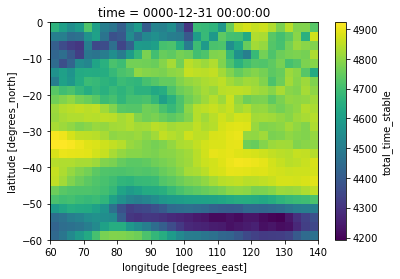

In [28]:
stable_ds.total_time_stable.plot()

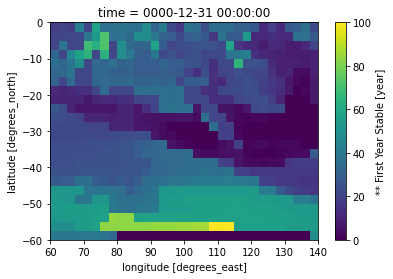

In [30]:
stable_ds.first_stable.plot()

# Procssing and Saving All Models

In [ ]:
def get_all_data_for_model(model)

In [15]:
model = models[3]
model

fname_experiment = [f for f in fnames_experiment if model in f][0]
fname_control = [f for f in fnames_control if model in f][0]
print(fname_experiment, fname_control)

fname_experiment_loess = [f for f in fnames_experiment_loess if model in f][0]
fname_control_loess = [f for f in fnames_control_loess if model in f][0]
print(fname_experiment_loess, fname_control_loess)

# Opening data for control and experiment
single_experiment =  xr.open_dataset(os.path.join(LONGRUNMIP_RETIMED_DIR,fname_experiment),
                             use_cftime = True, chunks = chunks).tas



single_control = xr.open_dataset(os.path.join(LONGRUNMIP_RETIMED_DIR,fname_control),
                             use_cftime = True, chunks = chunks).tas

# Opening data for control and experiment
single_experiment_loess =  xr.open_dataset(os.path.join(LONRUNMIP_LOESS_DIR, fname_experiment_loess),
                             use_cftime = True, chunks = chunks).tas


single_control_loess = xr.open_dataset(os.path.join(LONRUNMIP_LOESS_DIR, fname_control_loess),
                             use_cftime = True, chunks = chunks).tas

'GISSE2R'

## Calculations

In [20]:
# Getting the anomalies for the experiment
experiment_anom = single_experiment.clima.anomalies(start = single_experiment.time.dt.year.values[0], 
                                          end = single_experiment.time.dt.year.values[-1],
                            historical = single_experiment)
experiment_anom

Using historical dataset


<xarray.DataArray 'tas' (time: 5001, lat: 72, lon: 144)>
dask.array<rechunk-merge, shape=(5001, 72, 144), dtype=float32, chunksize=(8, 24, 48), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 5000-12-31 00:00:00
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8

In [21]:
lat = slice(-60, 0)
lon = slice(60,140)
time = slice(0,None)

In [22]:
da = experiment_anom.sel(lat = lat, lon = lon).isel(time=time)
control = single_control.sel(lat = lat, lon = lon).isel(time=time)
da_loess = single_experiment_loess.sel(lat = lat, lon = lon).isel(time=time)
control_loess = single_control_loess.sel(lat = lat, lon = lon).isel(time=time)

In [23]:
sn.global_sn

<function signal_to_noise.global_sn(da: xarray.core.dataarray.DataArray, control: xarray.core.dataarray.DataArray, da_loess: Optional[xarray.core.dataarray.DataArray] = None, control_loess: Optional[xarray.core.dataarray.DataArray] = None, window=61, return_all=False, logginglevel='ERROR') -> xarray.core.dataarray.DataArray>

In [24]:
%%time
da_test_sn, da_test_sn_stable, da_test_sn_increasing, da_test_sn_decreasing =\
        sn.global_sn(da, control, da_loess, control_loess, window= 51)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:1650: FutureWarning: The `numpy.nanpercentile` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:1650: FutureWarning: The `numpy.nanpercentile` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


CPU times: user 37min 15s, sys: 10min 19s, total: 47min 35s
Wall time: 41min 10s


In [25]:
da_test_sn = da_test_sn.compute()

In [26]:
da_test_sn_stable = da_test_sn_stable.compute()

In [27]:
%%time
stable_ds = da_test_sn_stable.sn.calculate_consecutive_metrics()
stable_ds = stable_ds.compute()

[        nan         nan         nan ... -1.21850335 -1.03029068
 -0.72678066]
[        nan         nan         nan ... -1.18837949 -0.9938767
 -0.71007142]
[        nan         nan         nan ... -1.13463595 -0.94732294
 -0.68506984]
[        nan         nan         nan ... -1.09284558 -0.90426853
 -0.66619126]
[        nan         nan         nan ... -1.09180937 -0.87966129
 -0.65180763]
[        nan         nan         nan ... -1.12619225 -0.89729821
 -0.66681996]
[        nan         nan         nan ... -1.1630838  -0.93697496
 -0.72129289]
[        nan         nan         nan ... -1.16104621 -0.94322164
 -0.76369848]
[ 1.55745533  1.66822696  1.72998673 ... -1.17272857 -0.92893591
 -0.75511322]
[ 1.39353855  1.49869702  1.5645134  ... -1.22098175 -0.95396015
 -0.75850517]
[ 1.42251677  1.51366777  1.58413345 ... -1.19038094 -0.91745117
 -0.71493885]
[ 1.39150135  1.4730231   1.55300217 ... -1.17891136 -0.89019388
 -0.67030713]
[ 1.31526346  1.38875227  1.48930785 ... -1.24657624 

[        nan         nan         nan ... -1.08476586 -0.85012201
 -0.68343279]
[        nan         nan         nan ... -1.13675882 -0.87071071
 -0.70502158]
[        nan         nan         nan ... -1.2379392  -0.96494086
 -0.7933892 ]
[        nan         nan         nan ... -1.38499972 -1.11648515
 -0.95131161]
[        nan         nan         nan ... -1.47142661 -1.19843811
 -1.01759516]
[        nan         nan         nan ... -1.49011392 -1.21128742
 -1.01483287]
[        nan         nan         nan ... -1.43923194 -1.17344577
 -0.9931934 ]
[        nan         nan         nan ... -1.3092358  -1.07379309
 -0.9075518 ]
[        nan         nan         nan ... -1.24234375 -1.03177954
 -0.8466502 ]
[        nan         nan         nan ... -1.21896008 -1.01983767
 -0.81465399]
[        nan         nan         nan ... -1.19892417 -1.00363864
 -0.80171865]
[        nan         nan         nan ... -1.12842011 -0.93172735
 -0.73232501]
[        nan         nan         nan ... -0.98418887

[        nan         nan         nan ... -0.3286005  -0.15562777
 -0.11522016]
[        nan         nan         nan ... -0.37324348 -0.21383148
 -0.16556052]
[        nan         nan         nan ... -0.45032265 -0.29279422
 -0.22357146]
[        nan         nan         nan ... -0.46912747 -0.32775384
 -0.2292765 ]
[        nan         nan         nan ... -0.56297617 -0.44626177
 -0.28370406]
[        nan         nan         nan ... -0.6925295  -0.62310397
 -0.41315236]
[        nan         nan         nan ... -0.85594018 -0.82122243
 -0.56914252]
[        nan         nan         nan ... -1.02847436 -1.0263373
 -0.73196111]
[        nan         nan         nan ... -1.159578   -1.16329528
 -0.83584972]
[        nan         nan         nan ... -1.23111914 -1.21565643
 -0.90300149]
[        nan         nan         nan ... -1.2712448  -1.22949368
 -0.92656415]
[        nan         nan         nan ... -1.30654983 -1.2334823
 -0.94705805]
[        nan         nan         nan ... -1.28598693 -

[        nan         nan         nan ... -1.46602843 -1.46767982
 -1.31476023]
[        nan         nan  1.05710195 ... -0.52647568 -0.58654178
 -0.35990464]
[ 1.05334996  1.0031755   0.77159678 ... -0.44244164 -0.49640733
 -0.34716383]
[ 1.24318939  1.23097749  1.08124898 ... -0.35329521 -0.41332919
 -0.3477301 ]
[ 1.05108967  1.03719517  0.94649699 ... -0.14343206 -0.19611693
 -0.13566067]
[ 1.09620123  1.12060522  1.04151956 ... -0.32225405 -0.36266171
 -0.36813302]
[ 1.0450187   1.08923805  1.04164417 ... -0.41484472 -0.38588736
 -0.34999947]
[ 0.59264453  0.59618568  0.56019633 ... -0.29023719 -0.20650303
 -0.24061318]
[ 0.33807818  0.32123221  0.36854821 ... -0.48741789 -0.49478398
 -0.56288572]
[ 0.54935128  0.6162778   0.65706908 ... -0.66270832 -0.74975842
 -0.79177131]
[ 0.62794744  0.62915283  0.64300833 ... -0.46731528 -0.57958679
 -0.60326061]
[        nan         nan         nan ...  0.27288503 -0.02206987
 -0.20569703]
[        nan         nan         nan ...  0.23758033

[        nan         nan         nan ... -1.09789004 -1.03677774
 -0.90403076]
[        nan         nan         nan ... -1.16434673 -1.15457358
 -0.95903809]
[        nan         nan         nan ... -1.21969609 -1.2224856
 -1.03509017]
[        nan         nan         nan ... -1.21642127 -1.21837804
 -1.05651582]
[        nan         nan         nan ... -1.26332962 -1.25280649
 -1.0965144 ]
[        nan         nan         nan ... -1.29298318 -1.26413506
 -1.14953468]
[        nan         nan         nan ... -1.21257235 -1.18882186
 -1.11617954]
[        nan         nan         nan ... -0.86009358 -0.84966892
 -0.87529417]
[        nan         nan         nan ... -0.45012655 -0.30641563
 -0.52205851]
[        nan         nan         nan ... -0.30104091 -0.23582835
 -0.43281533]
[        nan         nan         nan ... -0.17547503 -0.18043145
 -0.43021933]
[        nan         nan         nan ...  0.04161933  0.02676116
 -0.16745959]
[       nan        nan        nan ... 0.19663888 0.17

[       nan        nan        nan ... 0.71917594 0.32048801 0.18629859]
[       nan        nan        nan ... 0.75142336 0.93677778 0.47996061]
[       nan        nan        nan ... 0.80429435        nan 0.55554566]
[       nan        nan        nan ... 0.57539478 0.91212618 0.46407464]
[       nan        nan        nan ... 0.69365613 1.11885946 0.67052318]
[       nan        nan        nan ... 0.14264007 0.37087224 0.03549417]
[        nan         nan         nan ... -0.0257461   0.35898653
  0.22384865]
[        nan         nan         nan ... -0.08388468  0.04685105
 -0.0627898 ]
[        nan         nan         nan ... -0.04715565  0.1873184
  0.05515332]
[        nan         nan         nan ...  0.15359452  0.21814145
 -0.00454516]
[        nan         nan         nan ... -0.30440795 -0.21589905
 -0.19585677]
[       nan        nan        nan ... 0.07975157 0.13348662 0.19404748]
[       nan        nan        nan ... 0.2645465  0.28856259 0.43724157]
[        nan         nan      

# Plots Samples

In [ ]:
fig = plt.figure(figsize = (25,15))
time_index = 299


ax = fig.add_subplot(411, projection=ccrs.PlateCarree())
plot1 = da_test_sn.isel(time = time_index).plot(ax=ax, cmap='BrBG_r')
ax.coastlines()
time_val = da_test_sn.time.values[time_index]
ax.set_title(f'Year - {time_val.year}', fontsize = 25)


ax = fig.add_subplot(412, projection=ccrs.PlateCarree())
da_test_sn_stable.isel(time = time_index).plot(ax=ax, cmap='BrBG_r', 
                                              vmin = plot1.get_clim()[0], vmax = plot1.get_clim()[1])
ax.coastlines()
time_val = experiment_sn.time.values[time_index]
ax.set_title('Stable')


ax = fig.add_subplot(413, projection=ccrs.PlateCarree())
da_test_sn_increasing.isel(time = time_index).plot(ax=ax, cmap='BrBG_r', 
                                              vmin = plot1.get_clim()[0], vmax = plot1.get_clim()[1])
ax.coastlines()
time_val = experiment_sn.time.values[time_index]
ax.set_title('Increasing Unstable');



ax = fig.add_subplot(414, projection=ccrs.PlateCarree())
da_test_sn_decreasing.isel(time = time_index).plot(ax=ax, cmap='BrBG_r', 
                                              vmin = plot1.get_clim()[0], vmax = plot1.get_clim()[1])
ax.coastlines()
time_val = da_test_sn.time.values[time_index]
ax.set_title('Decreasing Unstable');

# fig.savefig(f'{IMG_DIR}/{model}_{time_index}_sn.png', bbox_inches='tight', dpi=500)

In [ ]:
data_vars = list(stable_ds.data_vars)

figsize = (25, 4 * len(data_vars))
num_plots= len(data_vars)

fig = plt.figure(figsize=figsize)


for pnum, var in enumerate(data_vars):
    ax = fig.add_subplot(int(num_plots/2) + 1, 2, pnum + 1, projection=ccrs.PlateCarree())
    
    stable_ds[var].plot(ax=ax, cmap='Reds', robust=True)
    ax.coastlines()

    ax.set_title(stable_ds[var].long_name, size=15)
    
fig.savefig(f'{IMG_DIR}/{model}_stable_metrics.png', bbox_inches='tight', dpi=500)

#### Lat Lon Exploration

In [ ]:
loc = Locations.MELBOURNE

sel_kwarg = dict(lat = loc.value[0], lon = loc.value[1], method='nearest')

In [ ]:
loc.name

In [ ]:
reload(sn_plot)

In [ ]:
fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)

sn_plot.temperature_vs_sn_plot(ax,  abrupt_sn.sel(**sel_kwarg), abrupt_anom.sel(**sel_kwarg),
                      temp_highlight = abrupt_anom_stable.sel(**sel_kwarg), 
                      sn_highlight = abrupt_sn_stable.sel(**sel_kwarg))

ax.set_title(loc.name, fontsize = 15);

In [ ]:
loc.name.capitalize()

In [ ]:
for loc in Locations:
    fig = plt.figure(figsize=  (15,10))
    ax = fig.add_subplot(111)


    sel_kwarg = dict(lat = loc.value[0], lon = loc.value[1], method='nearest')
    sn_plot.temperature_vs_sn_plot(ax,  abrupt_sn.sel(**sel_kwarg), abrupt_anom.sel(**sel_kwarg),
                          temp_highlight = abrupt_anom_stable.sel(**sel_kwarg), 
                          sn_highlight = abrupt_sn_stable.sel(**sel_kwarg))

    ax.set_title(f'{loc.name.capitalize()} ({loc.value[0]}$^\circ$, {loc.value[1]}$^\circ$)')
    
    fig.savefig(f'{IMG_DIR}/{model}_{loc.name.capitalize()}_sn_temp_anomaly.png', bbox_inches='tight', dpi=500)

# Grid Vs Global Space Mean

In [ ]:
stable_ds

In [ ]:
stable_ds['stable_year_anom_rel_global'] = stable_ds.first_stable - stable_smean_ds.first_stable.values

In [ ]:

figsize = (25, 8 )
fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

stable_ds['stable_year_anom_rel_global'].plot(ax=ax, cmap='BrBG', robust=True, extend='both')
ax.coastlines()

ax.set_title('Stable Year Vs Global Stablisation')